In [1]:
# Install needed stuff to the Jupyter and kernel environment
# Need to install only once, so commented out for cleaner output
# %pip install pyarrow
# %pip install pandas
# %pip install numpy
# %pip install matplotlib
# %pip install pyfinance
# %pip install yfinance
# %pip install yahoo-fin

In [3]:
# Import needed stuff
import sys
import pyarrow.feather as feather
import math
import pandas
import numpy as np
import matplotlib.pyplot as plt
from pyfinance.options import BSM
import yfinance as yf
from datetime import datetime, timedelta, date
from yahoo_fin import options as op

In [4]:
# General Delta-hedging function
def number_of_shares_to_buy(shares_per_contract, number_of_options, delta_of_option):
    delta_of_underlying = 1 # why?

    # Delta-hedging says:
    # number_of_shares * delta_of_underlying + number_of_options * delta_of_option = 0
    number_of_shares = (-number_of_options * delta_of_option / delta_of_underlying ) * shares_per_contract

    print("To delta-hedge the portoflio, you need to",("buy" if number_of_shares >= 0 else "sell"), round(np.abs(number_of_shares),2), "shares.")
    return number_of_shares


In [5]:
# General volatility function
def get_volatility(stock_data):
    log_returns = np.log(stock_data/stock_data.shift(1)).dropna()
    volatility = log_returns.rolling(window = 21).std() * np.sqrt(252)
    return volatility
    

In [6]:
# General plot function
def plot_stock_price_and_volatility(stock_prices, volatility):
    fig, ax = plt.subplots()
    ax.plot(stock_prices, color='red')
    ax.set_xlabel('Date', fontsize = 14)
    ax.set_ylabel('Underlying price', color='red', fontsize = 14)
    
    ax2 = ax.twinx()
    ax2.plot(volatility, color = 'blue')
    ax2.set_ylabel('Volatility', color = 'blue', fontsize = 14)
    
    plt.show()
    

## Let's use Apple stock data from Refinitiv here

Delta of the call option: 0.56291693680677
Delta of the put option: -0.43708306319323
To delta-hedge the portoflio, you need to sell 56.29 shares.
To delta-hedge the portoflio, you need to buy 43.71 shares.


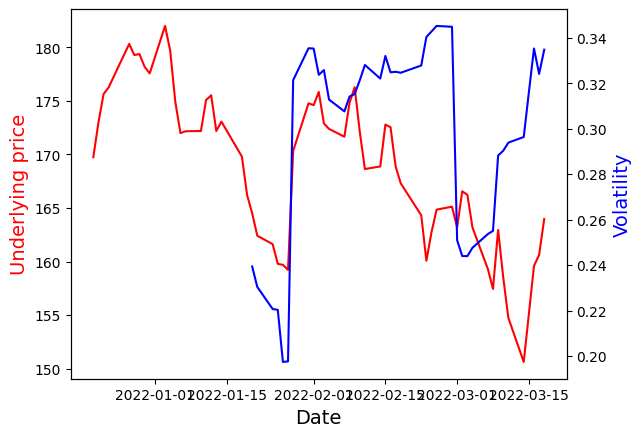

In [7]:
# Read data and show it, data is from Refinitiv workspace
apple_stock_data_as_df = feather.read_feather('../data/fe2.feather')

# Set date to index instead of running index from 1..n
date_as_index = apple_stock_data_as_df.set_index('Date', inplace=False)

vola = get_volatility(date_as_index['Underlying'])

# Set values
shares_per_contract = 100 # How this is determined ?

number_of_options = 1 # How this is determined? 1 stock = 1 option, n stocks = n options?

# Use Black-Scholes model to compute the delta of the call option
# T = maturity and r = interest rate just thrown there, no spesific reason I guess to be those
call_delta = BSM(kind='call', S0=date_as_index['Underlying'].iloc[-1], K=date_as_index['Underlying'].iloc[-1], T=0.25, r=0.05, sigma=vola.iloc[-1]).delta()

# Delta of the call option is always positive and between 0 and 1
print("Delta of the call option:", call_delta)

# Use Black-Scholes model to compute the delta of the put option
# Again T = maturity and r = interest rate are just thrown there, no spesific reason to be those (I think)
put_delta = BSM(kind='put', S0=date_as_index['Underlying'].iloc[-1], K=date_as_index['Underlying'].iloc[-1], T=0.25, r=0.05, sigma=vola.iloc[-1]).delta()

# Delta of the put option is always negative and between 0 and -1
print("Delta of the put option:", put_delta)

# Get the amounts to balance, aka delta-hedge the portfolio
how_many_shares_to_sell = number_of_shares_to_buy(shares_per_contract, number_of_options, call_delta)

how_many_shares_to_buy = number_of_shares_to_buy(shares_per_contract, number_of_options, put_delta)

plot_stock_price_and_volatility(date_as_index['Underlying'], vola)

# Lets try with S&P 500 data

[*********************100%%**********************]  1 of 1 completed


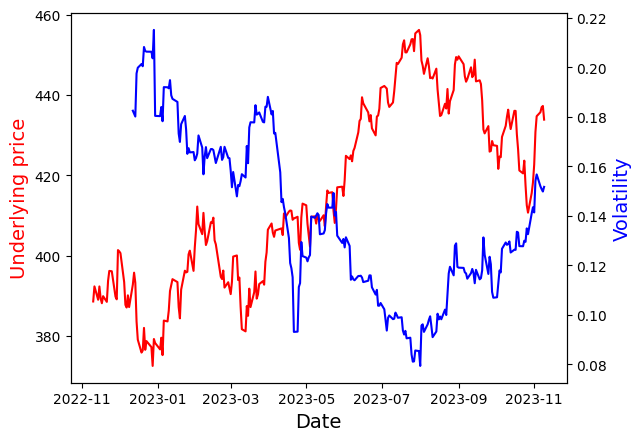

Delta of the call option: 0.580327235273375
Delta of the put option: -0.41967276472662496
To delta-hedge the portoflio, you need to sell 58.03 shares.
To delta-hedge the portoflio, you need to buy 41.97 shares.


In [8]:
stock_name = 'SPY'
years = 1
stock_data = yf.download(tickers = stock_name, start = datetime.today() - timedelta(days=years*365), end = datetime.today())

stock_data # Date as index, Open, High, Low, Close, Adj Close, Volume

stock_prices = stock_data['Adj Close'] # Closing prices
spy_vola = get_volatility(stock_prices)
plot_stock_price_and_volatility(stock_prices, spy_vola)

# Set values
shares_per_contract = 100 # How this is determined ?

number_of_options = 1 # How this is determined? 1 stock = 1 option, n stocks = n options?

# Use Black-Scholes model to compute the delta of the call option
# T = maturity and r = interest rate just thrown there, no spesific reason I guess to be those
call_delta = BSM(kind='call', S0=stock_prices.iloc[-1], K=stock_prices.iloc[-1], T=0.25, r=0.05, sigma=spy_vola.iloc[-1]).delta()

# Delta of the call option is always positive and between 0 and 1
print("Delta of the call option:", call_delta)

# Use Black-Scholes model to compute the delta of the put option
# Again T = maturity and r = interest rate are just thrown there, no spesific reason to be those (I think)
put_delta = BSM(kind='put', S0=stock_prices.iloc[-1], K=stock_prices.iloc[-1], T=0.25, r=0.05, sigma=spy_vola.iloc[-1]).delta()

# Delta of the put option is always negative and between 0 and -1
print("Delta of the put option:", put_delta)

# Get the amounts to balance, aka delta-hedge the portfolio
how_many_shares_to_sell = number_of_shares_to_buy(shares_per_contract, number_of_options, call_delta)

how_many_shares_to_buy = number_of_shares_to_buy(shares_per_contract, number_of_options, put_delta)

# Hedging assigment

# Fetch real option data using Yahoo_fin

### This approach is work in progress for now

In [12]:
# Another viable dataset
def fetch_sp500_yahoofin():
    ticker = 'SPY'
    expiration_dates = op.get_expiration_dates(ticker)
    exp = pandas.DataFrame(expiration_dates)
    # print(exp)
    calls = op.get_calls(ticker, date = expiration_dates[13]) # Chose 29.12.2023 
    c = pandas.DataFrame(calls)
    print(c)
    
    long_position_in_call = c.iloc[0]
    print(long_position_in_call)
    print(long_position_in_call['Strike'])
    
    #puts = op.get_puts(ticker, date = expiration_dates[14])
    #print(puts)
    #chain_data = op.get_options_chain(ticker, date=expiration_dates[14])
    #print(chain_data)

# Fetch using yfinance

### Data fetching and wrangling

In [ ]:
# Get sp500 index data from Yahoo Finance

def get_data():
    
    sp500 = yf.Ticker('SPY')
    
    # Get expiration dates of the options to a dataframe
    expiration_dates = pandas.DataFrame(data=sp500.options)
    
    # Debug print
    print(expiration_dates)
    
    # Get expiration date, which is around 45 days to maturity from this day, in this case 29.12.2023
    expiration = expiration_dates.iloc[12][0]
    
    # Get the option chain for the sp500 data
    option_chain_for_expiration = sp500.option_chain(expiration) # expiration 29.12.2023
    
    # We will use call options for the hedging assignment, construct them to a dataframe
    opt_calls = pandas.DataFrame(option_chain_for_expiration.calls)
    
    # Debug print
    print(opt_calls)
    
    # Get also the Put options and construct them to a dataframe
    # Optional and not needed yet in the assignment
    opt_puts = pandas.DataFrame(option_chain_for_expiration.puts)

### Write the data to files

In [25]:
# NOTE !! Running this cell will overwrite the current files and data in the directory

def write_files():
    # NOTE !! Running this cell will overwrite the current files and data in the directory
    
    # Write expiration dates to a .csv file to same directory
    expiration_dates.to_csv('sp500_expiration_dates_' + str(datetime.today()) + '.csv', sep='\t', index=False)
    
    # Write call options for the certain expiration date to a .csv file in the same directory
    opt_calls.to_csv('sp500_calls_' + str(datetime.today()) + '.csv', sep='\t', index=False)
    
    # Write puts to a .csv file in the same directory
    opt_puts.to_csv('sp500_puts_' + str(datetime.today()) + '.csv', sep='\t', index=False)

## The hedging function itself

In [74]:
def delta_hedge():
    expirations = pandas.read_csv('sp500_expiration_dates_2023-11-10 11:47:07.709639.csv', sep='\t')
    calls = pandas.read_csv('sp500_calls_2023-11-10 11:47:07.714281.csv', sep='\t')

    # This option has the last price and strike price very close to each other
    # You can brosw the option data to confirm
    option = calls.iloc[8] 
    print(option)

    # Get the days to maturity
    days_to_maturity = datetime(2023, 12, 29) - datetime.today()
    
    # Get time to maturity in years
    t = int(days_to_maturity.days)/365
    
    # Debug print
    print(t)
    print("Days to maturity in days is", days_to_maturity.days) # 49 days_to_maturity
    
    # time at t = 0, the date when the date was pulled
    t0 = datetime(2023, 11, 9).date()
    print("Time at t = 0 aka when data was fetched", t0)
    
    # call option with price C0 at time t0
    c0 = option['lastPrice']
    print('Price of Call option c0 in time t0', c0)

    # Strike price
    strike = option['strike']
    print('Strike price is: ', strike)
    
    # US treasury 10-year bond yield?
    r = 0.05
    
    # What would be a good value? 0.2 is used in the exercies
    sigma = 0.2
    
    # Value of the BSM for the call option c0 at time t0
    val = BSM(kind='call', S0=c0, K=strike, T=t, r=r, sigma=sigma).value() 
    print('value from BSM', val)
    
    # Delta of the BSM for the call option c0 at time t0
    delta = BSM(kind='call', S0=c0, K=strike, T=t, r=r, sigma=sigma).delta()
    print('Delta from BSM', delta)
    
    # Construct two portfolios:
    # OP with a long position in a call option
    # RE which is a short position of number of delta of the underlying asset
    
    # OP
    op = c0
    print('Long position in a call option c0 is ', c0)
    
    # RE
    re = -1*delta * c0
    print('Short position re ', re)

    # Portfolio value according to lecture 7
    portfolio_value = c0 - delta*c0
    print('Portfolio value ', portfolio_value)
    
    # Changes in the portfolio OP are neutralized by oppsite changes in the replicatin portfolio re
    # rehedge every second day
    # Compute how much every portfolio has changed
    # Count mean squared error

In [75]:
delta_hedge()

contractSymbol              SPY240119C00220000
lastTradeDate        2023-11-03 17:51:39+00:00
strike                                   220.0
lastPrice                               216.33
bid                                        0.0
ask                                        0.0
change                                     0.0
percentChange                              0.0
volume                                     2.0
openInterest                                 0
impliedVolatility                      0.00001
inTheMoney                                True
contractSize                           REGULAR
currency                                   USD
Name: 8, dtype: object
0.13150684931506848
Days to maturity in days is 48
Time at t = 0 aka when data was fetched 2023-11-09
Price of Call option c0 in time t0 216.33
Strike price is:  220.0
value from BSM 5.238796930172967
Delta from BSM 0.45817896616098175
Long position in a call option c0 is  216.33
Short position re  -99.11785574960518
